## STEP 1: Install Libraries

In [1]:
!pip install spotipy requests kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.9/268.9 kB 25.0 MB/s eta 0:00:00


## STEP 2: Check Runtime Type

In [2]:
import os
import torch
import tensorflow as tf

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print("✔️ TPU found:", tpu.master())

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.TPUStrategy(tpu)
    print("✔️ TPU initialized and ready.")
except ValueError:
    print("❌ TPU not found. Please check your runtime settings.")

❌ TPU not found. Please check your runtime settings.


In [4]:
if 'COLAB_TPU_ADDR' in os.environ:
    hardware = "TPU"
elif torch.cuda.is_available():
    hardware = "GPU"
else:
    hardware = "CPU"

print("Running on:", hardware)

Running on: GPU


## STEP 3: Authenticate with Spotify

In [5]:
# import library
import requests
import json
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import kagglehub
import concurrent.futures
import time

benchmark_results = []

In [6]:
# Record the start time for benchmarking the authentication step
auth_start = time.time()

# Create a SpotifyOAuth object using credentials from the Spotify Developer Console
# This handles the OAuth2 flow including token exchange
sp_oauth = SpotifyOAuth(
    client_id='c8114cb722874ba89ea096a76b613552',  # Your Spotify Client ID
    client_secret='2b5ee9bf48754806a809aff449714616',  # Your Spotify Client Secret
    redirect_uri='https://example.com/callback',  # Redirect URI set in your Spotify App
    scope='user-top-read playlist-modify-public'  # Permissions: read top tracks + modify playlists
)

# Generate the authentication URL and prompt user to authorize the app
auth_url = sp_oauth.get_authorize_url()
print("Go to the following URL to authorize access:", auth_url)

# After the user authorizes, they will be redirected — paste that URL here
redirected_url = input("Paste the redirected URL here:\n")

# Extract the authorization code from the redirected URL
code = sp_oauth.parse_response_code(redirected_url)

# Use the authorization code to get an access token
sp_oauth.get_access_token(code)

# Store the access token for use in Spotify Web API requests
token = sp_oauth.get_cached_token()['access_token']

# Record end time and log benchmark result for this step
auth_end = time.time()
benchmark_results.append({'step': 'auth', 'runtime': auth_end - auth_start})

Go to the following URL to authorize access: https://accounts.spotify.com/authorize?client_id=c8114cb722874ba89ea096a76b613552&response_type=code&redirect_uri=https%3A%2F%2Fexample.com%2Fcallback&scope=user-top-read+playlist-modify-public
Paste the redirected URL here:
 https://example.com/callback?code=AQCaMQE9WHxafED_VfSkmutvpfPQM8TYOwpwfwwYOYL1RYWzhKkBaNhk-ODemtvzQRx0wrwYKIQMYXUyc66rKsG6It5iYpy36KzYaC6ZT2ith0WFYtAmJt4yY6KDfQ4VgKV8Kcsp3bmT9aO3riV9pW3YkZ9T1OMPKYfSLR4IFJ0Rszpn2YDie2N9iRgQZXKCM0OMfR5ZCsVAAIJdoKXai-SyVprw15o


<ipython-input-6-6f24efb45267>:24: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  sp_oauth.get_access_token(code)


## STEP 4: Fetch User's Top Tracks from Spotify

In [7]:
# Record the start time to benchmark the data-fetching process
fetch_start = time.time()

# --------------------------------------------
# Helper function to call Spotify Web API
# --------------------------------------------
def fetch_web_api(endpoint, method, body=None):
    """
    Sends a request to the specified Spotify API endpoint using the provided method and optional JSON body.
    Requires a valid OAuth token.

    Args:
        endpoint (str): The Spotify API path (e.g., 'v1/me/top/tracks').
        method (str): HTTP method (e.g., 'GET', 'POST').
        body (dict, optional): Data to be sent in the request body.

    Returns:
        dict: JSON response from the Spotify API.
    """
    headers = {
        'Authorization': f'Bearer {token}',       # Bearer token from Spotify OAuth
        'Content-Type': 'application/json'
    }

    # Send HTTP request to Spotify API
    response = requests.request(
        method,
        f'https://api.spotify.com/{endpoint}',     # Full URL to the API endpoint
        headers=headers,
        data=json.dumps(body) if body else None
    )

    # Handle potential errors
    if response.status_code != 200:
        print(f"Error {response.status_code}: {response.text}")
        response.raise_for_status()

    return response.json()

# --------------------------------------------
# Fetch top 20 tracks the user listened to long-term
# --------------------------------------------
top_tracks = fetch_web_api('v1/me/top/tracks?time_range=long_term&limit=20', 'GET')['items']

# --------------------------------------------
# Display track names and artists
# --------------------------------------------
print("\n♥︎ My Top Tracks:")
for idx, track in enumerate(top_tracks, start=1):
    name = track['name']
    artists = ', '.join(artist['name'] for artist in track['artists'])
    print(f"{idx}. {name} by {artists}")

# Record end time and log benchmark result
fetch_end = time.time()
benchmark_results.append({'step': 'fetch_top_tracks', 'runtime': fetch_end - fetch_start})


♥︎ My Top Tracks:
1. DARARI by TREASURE
2. Love by Keyshia Cole
3. เส้นบางๆ by Indigo
4. Let Me Love You by DJ Snake, Justin Bieber
5. Bills by ENHYPEN
6. Blind by ENHYPEN
7. SHOUT OUT by ENHYPEN
8. Strings by TAEMIN
9. Fall in Love by ARMOR
10. ฉบับปรับปรุง by ZENTYARB, PUNYARB, LAZYLOXY
11. Scent by oceanfromtheblue
12. Fate by ENHYPEN
13. วันครบเลิก by NONT TANONT
14. What Makes You Beautiful by ENHYPEN
15. Everyday by Ariana Grande, Future
16. Sacrifice (Eat Me Up) by ENHYPEN
17. Bite Me by ENHYPEN
18. BLOSSOM by ENHYPEN
19. สตรอว์เบอร์รีไอศกรีม by MXFRUIT
20. Summer (Feat. BE’O) by Paul Blanco, BE'O


## STEP 5: Import Spotify Tracks Dataset from Kaggle (FMA)

In [8]:
# Record the start time to benchmark dataset download + load time
dataset_start = time.time()

# --------------------------------------------
# Download dataset using KaggleHub
# --------------------------------------------
# The dataset is publicly available at:
# https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

# Show where the dataset is downloaded
print("Path to dataset files:", path)

# Display available files in the dataset directory
print("Files in the dataset:", os.listdir(path))

# --------------------------------------------
# Load the dataset CSV into a Pandas DataFrame
# --------------------------------------------
file_path = os.path.join(path, "dataset.csv")  # Absolute path to CSV file
df = pd.read_csv(file_path)  # Load CSV using buffered read (via pandas)

# Record end time and log benchmark result
dataset_end = time.time()
benchmark_results.append({'step': 'download_dataset', 'runtime': dataset_end - dataset_start})

100%|██████████| 8.17M/8.17M [00:01<00:00, 5.90MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/maharshipandya/-spotify-tracks-dataset/versions/1
Files in the dataset: ['dataset.csv']


## STEP 6: Build User Music Profile from Top Tracks

In [9]:
# Record the start time to benchmark the profile creation process
process_start = time.time()

# --------------------------------------------
# Extract Spotify track IDs from the user's top tracks
# --------------------------------------------
track_ids = [track['id'] for track in top_tracks]  # List of track IDs to match with dataset

# --------------------------------------------
# Filter the Kaggle dataset to only include tracks that match the user's top Spotify tracks
# --------------------------------------------
# This performs a vectorized match using .isin() for efficiency
user_tracks_df = df[df['track_id'].isin(track_ids)]

# --------------------------------------------
# Define the audio features to include in the user profile
# --------------------------------------------
feature_keys = ['danceability', 'energy', 'valence', 'tempo', 'acousticness']

# Compute the mean of each feature to create a user profile vector
# This vector represents the user's average musical taste
user_profile = user_tracks_df[feature_keys].mean()

# Display the resulting profile
print("♥︎ User Profile (average audio features):\n", user_profile)

♥︎ User Profile (average audio features):
 danceability      0.632571
energy            0.706143
valence           0.231286
tempo           110.949000
acousticness      0.071236
dtype: float64


## STEP 7: Generate Music Recommendations Using KNN & Display Result

In [10]:
# ============================================
# STEP: Generate Music Recommendations Using KNN
# ============================================

from sklearn.neighbors import NearestNeighbors

# Prepare dataset for KNN (drop missing values in audio features)
df_filtered = df.dropna(subset=feature_keys)
X = df_filtered[feature_keys]

# Fit KNN model with Euclidean distance
knn = NearestNeighbors(n_neighbors=50, metric='euclidean')
knn.fit(X)

# Find 50 songs nearest to the user profile
distances, indices = knn.kneighbors([user_profile])

# Retrieve recommended songs based on indices
recommendations = df_filtered.iloc[indices[0]]

# 🔍 Remove duplicate tracks to ensure variety
recommendations = recommendations.drop_duplicates(subset=['track_name', 'artists'])

# Display genres of the recommended songs
print("Genres of Recommended Tracks:")
print(recommendations['track_genre'].tolist())


Genres of Recommended Tracks:
['electronic', 'j-pop', 'hardcore', 'club', 'minimal-techno', 'industrial', 'trip-hop', 'synth-pop', 'piano', 'indie', 'detroit-techno', 'electro', 'electro', 'trip-hop', 'industrial', 'idm', 'minimal-techno', 'death-metal', 'french', 'detroit-techno', 'synth-pop', 'deep-house', 'club', 'edm', 'club', 'deep-house', 'electro', 'electro', 'trip-hop', 'synth-pop', 'soul', 'soul']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [11]:
# --------------------------------------------
# Select only key columns for display
# --------------------------------------------
# Limit to top 20 recommendations for clearer presentation
display_df = recommendations[['track_name', 'artists', 'track_genre']].copy().head(20)

# Rename columns for aesthetic purposes (♥︎ label)
display_df.columns = ['♥︎ Track Name', '♥︎ Artist(s)', '♥︎ Genre']

# --------------------------------------------
# Render the table with HTML styling using IPython
# --------------------------------------------
from IPython.display import display, HTML

# Convert the DataFrame to an HTML table without index
html_table = display_df.reset_index(drop=True).to_html(index=False, escape=False)

# Define custom CSS style for the HTML table
display(HTML(f"""
<style>
table {{
  border-collapse: collapse;
  width: 100%;
  font-family: 'Arial';
  font-size: 15px;
}}
th {{
  background-color: #1DB954;  /* Spotify green */
  color: white;
  padding: 8px;
  text-align: right;
}}
td {{
  padding: 8px;
  border-bottom: 1px solid #ddd;
  text-align: right;
}}
</style>
{html_table}
"""))

♥︎ Track Name,♥︎ Artist(s),♥︎ Genre
Fasl E Gul,Farasat Anees;Slick Trick;Toshi,electronic
こんなに悲しいのに腹が鳴る,Creep Hyp,j-pop
Mulher,Rancore,hardcore
Are Friends Electric,Djedjotronic;Lokier,club
Half Age,Weval,minimal-techno
John Wayne Gacy,SKYND,industrial
Heartbroken - Live at Koningin Elisabethzaal 2012,Hooverphonic,trip-hop
Sweettalk my Heart,Tove Lo,synth-pop
Wreak Havoc,Skylar Grey,piano
You should be sad,Halsey,indie


## STEP 8: Create and Add Recommended Songs to Spotify Playlist

In [12]:
import time
import concurrent.futures

# --------------------------------------------------
# Prepare unique Spotify track URIs
# --------------------------------------------------
track_uris = ['spotify:track:' + tid for tid in recommendations['track_id'].dropna().tolist()]
track_uris = list(dict.fromkeys(track_uris))  # Remove duplicates but keep order
print(f"🎧 Total unique URIs to add: {len(track_uris)}")

# Split into batches of 100 (Spotify API limit)
def chunkify(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
batches = list(chunkify(track_uris, 100))

# Initialize Spotify client
sp = spotipy.Spotify(auth_manager=sp_oauth)
user_id = sp.me()['id']

# --------------------------------------------------
# Method 1: Single-threaded playlist creation
# --------------------------------------------------
playlist_single = sp.user_playlist_create(user=user_id, name='No Veggie Recs (Single Thread)', public=True)

start_time = time.time()
for batch in batches:
    sp.playlist_add_items(playlist_id=playlist_single['id'], items=batch)
single_thread_duration = time.time() - start_time

print(f"Single-thread took {single_thread_duration:.2f} seconds")
print(f"Playlist (Single): {playlist_single['external_urls']['spotify']}")

# --------------------------------------------------
# Method 2: Multi-threaded playlist creation
# --------------------------------------------------
playlist_multi = sp.user_playlist_create(user=user_id, name='No Veggie Recs (Multi Thread)', public=True)

def add_batch_to_playlist(batch):
    try:
        sp.playlist_add_items(playlist_id=playlist_multi['id'], items=batch)
        return True
    except Exception as e:
        print("Error:", e)
        return False

start_time = time.time()
max_threads = min(10, len(batches))
with concurrent.futures.ThreadPoolExecutor(max_workers=max_threads) as executor:
    futures = [executor.submit(add_batch_to_playlist, b) for b in batches]
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
multi_thread_duration = time.time() - start_time

print(f"Multi-thread took {multi_thread_duration:.2f} seconds")
print(f"Playlist (Multi): {playlist_multi['external_urls']['spotify']}")

# --------------------------------------------------
# Summary
# --------------------------------------------------
print(f"Speedup: {single_thread_duration / multi_thread_duration:.2f}x faster with multithreading")

🎧 Total unique URIs to add: 32
Single-thread took 0.14 seconds
Playlist (Single): https://open.spotify.com/playlist/5clKGlNGSTtyoW1kKEOFRN
Multi-thread took 0.15 seconds
Playlist (Multi): https://open.spotify.com/playlist/3PwsPFK8tZpb89NfkU3UBk
Speedup: 0.97x faster with multithreading


## STEP 9: Compare File I/O Performance (JSON)

In [13]:
# --------------------------------------------
# Save recommendations to JSON file
# --------------------------------------------
recommendations = pd.DataFrame(top_tracks)

filename = 'recommendations.json'

# Save in JSON Lines format (one object per line)
recommendations.to_json(filename, orient='records', lines=True)
print("❤︎ Saved as recommendations.json")

# --------------------------------------------
# Start benchmarking I/O methods
# --------------------------------------------
import time
io_start = time.time()

# --------------------------------------------
# Method 1: read() — read entire file as one string
# --------------------------------------------
start = time.time()
with open(filename, 'r') as f:
    data = f.read()  # Load whole file into memory at once
end = time.time()
print("📄 read() time:", end - start)
benchmark_results.append({'step': 'read()', 'runtime': end - start})

# --------------------------------------------
# Method 2: readline() — read file line-by-line into list
# --------------------------------------------
start = time.time()
with open(filename, 'r') as f:
    lines = [line for line in f]  # Load each line one-by-one
end = time.time()
print("📄 readline() time:", end - start)
benchmark_results.append({'step': 'readline()', 'runtime': end - start})

# --------------------------------------------
# Method 3: pandas.read_json() — structured loading with parsing
# --------------------------------------------
start = time.time()
df = pd.read_json(filename, lines=True)  # Fast and structured but includes parsing overhead
end = time.time()
print("📄 pandas.read_json() time:", end - start)
benchmark_results.append({'step': 'pandas.read_json()', 'runtime': end - start})

# --------------------------------------------
# Log total I/O benchmark time
# --------------------------------------------
io_end = time.time()
benchmark_results.append({'step': 'total_io', 'runtime': io_end - io_start})

❤︎ Saved as recommendations.json
📄 read() time: 0.0014996528625488281
📄 readline() time: 0.00028824806213378906
📄 pandas.read_json() time: 0.01893138885498047


## STEP 10: Save and Display Benchmark Results

In [14]:
import json

# --------------------------------------------
# Print hardware type (CPU / GPU / TPU)
# --------------------------------------------
print("🖥️ Using runtime type:", hardware)

# --------------------------------------------
# Save benchmark results to a JSON file
# --------------------------------------------
filename = f'benchmark_{hardware.lower()}.json'

# Write benchmark results as pretty-formatted JSON
with open(filename, 'w') as f:
    json.dump(benchmark_results, f, indent=2)

print(f"\n📁 Benchmark results saved to {filename}")

# --------------------------------------------
# Print all benchmark steps and their runtimes
# --------------------------------------------
print("\n⏱️ Runtime Summary:")
for step in benchmark_results:
    print(f"• {step['step']}: {step['runtime']:.4f} seconds")

🖥️ Using runtime type: GPU

📁 Benchmark results saved to benchmark_gpu.json

⏱️ Runtime Summary:
• auth: 8.8659 seconds
• fetch_top_tracks: 0.2580 seconds
• download_dataset: 8.8786 seconds
• read(): 0.0015 seconds
• readline(): 0.0003 seconds
• pandas.read_json(): 0.0189 seconds
• total_io: 0.0213 seconds


In [15]:
from google.colab import files
# files.download('benchmark_cpu.json')
files.download('benchmark_gpu.json')
# files.download('benchmark_tpu.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## STEP 11: Prepare Benchmark Data for Visualization

In [16]:
import pandas as pd
import json

uploaded = files.upload()
cpu = json.load(open('benchmark_cpu.json'))
uploaded = files.upload()
gpu = json.load(open('benchmark_gpu.json'))
# uploaded = files.upload()
# gpu = json.load(open('benchmark_tpu.json'))

Saving benchmark_cpu.json to benchmark_cpu.json


Saving benchmark_gpu.json to benchmark_gpu (1).json


In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------------------------
# Convert benchmark result lists to DataFrames
# --------------------------------------------
df_cpu = pd.DataFrame(cpu)  # List of dicts for CPU run
df_gpu = pd.DataFrame(gpu)  # List of dicts for GPU run
# df_tpu = pd.DataFrame(tpu)  # Optional: TPU benchmark

# Add device labels
df_cpu['device'] = 'CPU'
df_gpu['device'] = 'GPU'
# df_tpu['device'] = 'TPU'

# Combine all device benchmarks into a single DataFrame
# df_all = pd.concat([df_cpu, df_gpu, df_tpu])
df_all = pd.concat([df_cpu, df_gpu])

# Preview data for debugging
print(df_all.head())

               step   runtime device
0              auth  8.947842    CPU
1  fetch_top_tracks  0.253736    CPU
2  download_dataset  7.312022    CPU
3            read()  0.000625    CPU
4        readline()  0.000277    CPU


## STEP 12: Benchmark Runtime Visualization (Log Scale)

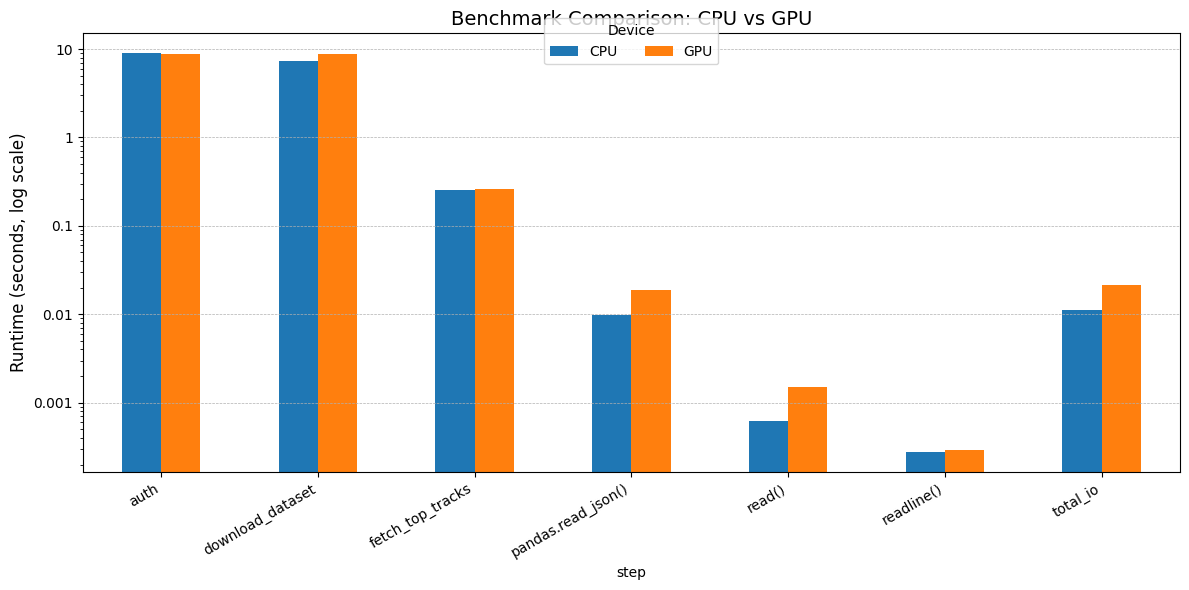

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --------------------------------------------
# Pivot data so each step has runtime for both devices (columns)
# --------------------------------------------
pivot = df_all.pivot(index='step', columns='device', values='runtime')

# Plot runtime comparison as bar chart with log scale
pivot.plot(kind='bar', figsize=(12, 6), logy=True)

# --------------------------------------------
# Customize Y-axis (log scale formatting)
# --------------------------------------------
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:g}'))

# --------------------------------------------
# Set axis labels and styling
# --------------------------------------------
plt.ylabel("Runtime (seconds, log scale)", fontsize=12)
plt.title("Benchmark Comparison: CPU vs GPU", fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add horizontal grid lines for readability
plt.grid(True, which="major", axis="y", linestyle='--', linewidth=0.5)

# Add legend above the chart
plt.legend(title="Device", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=3)

# Optimize layout
plt.tight_layout()

# Display plot
plt.show()